In [2]:
### import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [14]:
import os
os.chdir('../../')
os.getcwd()

'/lustre/eaglefs/projects/rlmolecule/jlaw/crystal-gnn-fork'

In [4]:
import utils

## Training of GNN model (loss vs iteration)

In [5]:
def plot_loss(df, title="", ax=None):
    ax.semilogy(df.epoch, df.loss, label='Training loss')
    ax.semilogy(df.epoch, df.val_loss, label='Validation loss')
    ax.axhline(.1, ls='--', color='.4')
    ax.legend(prop={'size':10})
    # plt.ylim([0.05, 0.2])

    ax.set_title(title)
    ax.set_ylabel('Mean Absolute Error (eV/atom)', fontsize=14)
    ax.set_xlabel('Training Epoch', fontsize=14)
#     ax.tight_layout()
    # plt.savefig('figs/training_curve.svg')

In [6]:
def plot_loss_single(df, title=""):
    plt.semilogy(df.epoch, df.loss, label='Training loss')
    plt.semilogy(df.epoch, df.val_loss, label='Validation loss')
    plt.axhline(.1, ls='--', color='.4')
    plt.legend()
    # plt.ylim([0.05, 0.2])

    plt.title(title)
    plt.ylabel('Mean Absolute Error\neV/atom')
    plt.xlabel('Training Epoch')
    plt.tight_layout()
    # plt.savefig('figs/training_curve.svg')
    plt.show()
    plt.close()

In [7]:
def read_mae_file(mae_file):
    """ TODO improve this file 
    Example file:
    Test MAE: 0.153 eV/atom
    Test RMSE: 0.2562296566890987
    ICSD MAE: 0.076 eV/atom
    Hypo MAE: 0.164 eV/atom
    """
    mae_vals = pd.read_csv(mae_file, sep=' ', header=None).values
    icsd_mae = mae_vals[2][2]
    hypo_mae = mae_vals[3][2]
    return icsd_mae, hypo_mae

In [8]:
def get_exp_description(exp, num_icsd=None, num_hypo=None):
    """ exp: experiment from yaml file
    """
    dataset_str = ', '.join(exp['datasets'])
    
    eval_sett = exp['eval_settings']
    icsd_str = f"{eval_sett['icsd_lattice']} lattice, {eval_sett['icsd']}"
    num_icsd_str = f" ({num_icsd})" if num_icsd is not None else ''
    icsd_str = f"ICSD eval{num_icsd_str}: {icsd_str}"

    hypo_str = f"{eval_sett['hypo_lattice']} lattice, {eval_sett['hypo']}"
    num_hypo_str = f" ({num_hypo})" if num_hypo is not None else ''
    hypo_str = f"Hypo eval{num_hypo_str}: {hypo_str}"
    
    eval_str = f"{icsd_str}\n{hypo_str}"
    return dataset_str, eval_str

In [10]:
def plot_train_and_parity(exp_dir, log_df, pred_df, icsd_df, out_dir=None):
    """ Plot the training curves and a parity plot

    :param pred_df: pandas dataframe containing the energy per atom
        as well as the predicted energy per atom
    :param icsd_df: pandas dataframe containing the IDs of ICSD structures
    """
    mae_file = exp_dir + "/mae_test.txt"
    icsd_mae, hypo_mae = read_mae_file(mae_file)

    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,4))
    
    plot_loss(log_df, ax=ax1)
    plot_parity(pred_df, icsd_df, icsd_mae, hypo_mae, ax=ax2)
    
    # now get the title for the plot
    config_file = exp_dir + "/run.yaml"
    config_map = utils.load_config_file(config_file)    
    num_icsd = len(pred_df[pred_df.id.isin(icsd_df.id)])
    num_hypo = len(pred_df[~pred_df.id.isin(icsd_df.id)])
    dataset_str, eval_str = get_exp_description(config_map['experiments'][0],
                                                num_icsd=num_icsd,
                                                num_hypo=num_hypo,
                                                )
    
    plt.suptitle(dataset_str, y=1.15, fontweight='bold', fontsize=16)
    plt.figtext(x=.25, y=0.975, s=eval_str, fontsize=14, ha='left')
    
    plt.tight_layout()
    
    out_file = f"{exp_dir}/train_and_parity_plots.svg"
    plt.savefig(out_file, bbox_inches='tight')
    if out_dir is not None:
        out_file = f"{out_dir}/{'_'.join(exp_dir.split('/')[-2:])}.svg"
        print(f"writing {out_file}")
        plt.savefig(out_file, bbox_inches='tight')

    plt.show()
    plt.close()


def plot_parity(pred_df, icsd_df, icsd_mae, hypo_mae, ax=None, out_file=None):
    icsd_pred_df = pred_df[pred_df.id.isin(icsd_df.id)]
    hypo_pred_df = pred_df[~pred_df.id.isin(icsd_df.id)]

    if ax is None:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, aspect='equal')
    ax.plot(icsd_pred_df.energyperatom, 
            icsd_pred_df.predicted_energyperatom, 
            '.', ms=2, c='b', 
            label=f'ICSD (MAE: {icsd_mae:0.3f})')
    ax.plot(hypo_pred_df.energyperatom, 
            hypo_pred_df.predicted_energyperatom, 
            '.', ms=2, c='r', 
            label=f'Hypothetical (MAE: {hypo_mae:0.3f})')
    ax.plot([-9, -1], [-9, -1], '--', color='.8', zorder=0)
    ax.set_xticks([-1, -3, -5, -7, -9])
    ax.set_yticks([-1, -3, -5, -7, -9])
    ax.legend(loc='upper left', frameon=False, prop={'size':10}, markerscale=6)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.tick_params(direction='in', length=5)
    #plt.ylabel('Energy per atom,\npredicted (eV/atom)', fontsize=12)
    #plt.xlabel('Energy per atom,\nDFT (eV/atom)', fontsize=12)
    ax.set_ylabel('Predicted Total Energy (eV/atom)', fontsize=14)
    ax.set_xlabel('DFT Total Energy (eV/atom)', fontsize=14)

    ax.text(1, 0.025, f'Test MAE: {(pred_df.energyperatom - pred_df.predicted_energyperatom.squeeze()).abs().mean():.3f} eV/atom',
            ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

    sns.despine(trim=False)
    if out_file is not None:
        plt.tight_layout()
        print("writing {out_file}")
        plt.savefig(out_file)

In [11]:
import glob
exp_dirs = list(glob.glob("outputs/icsd_*/*seed2")) + list(glob.glob("outputs/icsd_*/*seed3"))

In [17]:
exp_dirs = [
    "outputs/icsd_battery_unrelaxed/hypo_clatt_loc_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_unrelaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_relaxed_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_relaxed_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_relaxed/hypo_clatt_loc_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_relaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_relaxed/hypo_loc_icsd_randsub0_05_seed1",
    "outputs/icsd_battery_relaxed/hypo_randsub0_05_icsd_randsub0_05_seed1",
    "outputs/icsd_zintl_unrelaxed/hypo_clatt_loc_icsd_randsub0_05_seed1",
    "outputs/icsd_zintl_unrelaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1",
    "outputs/icsd_zintl_unrelaxed/hypo_loc_icsd_randsub0_05_seed1",
    "outputs/icsd_zintl_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1",
]
log_files = [d + '/log.csv' for d in exp_dirs]

In [15]:
icsd_file = "inputs/structures/icsd_energies.csv"
icsd_df = pd.read_csv(icsd_file)

Loading config file 'outputs/icsd_battery_unrelaxed/hypo_clatt_loc_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_unrelaxed_hypo_clatt_loc_icsd_randsub0_05_seed1.svg


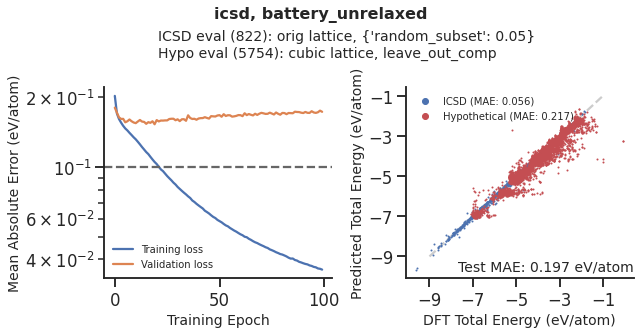

Loading config file 'outputs/icsd_battery_unrelaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_unrelaxed_hypo_clatt_randsub0_05_icsd_randsub0_05_seed1.svg


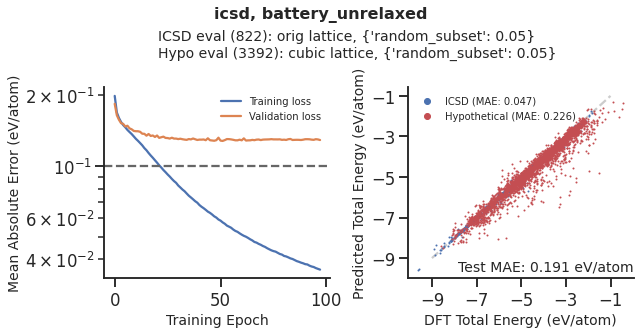

Loading config file 'outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_unrelaxed_hypo_loc_icsd_randsub0_05_seed1.svg


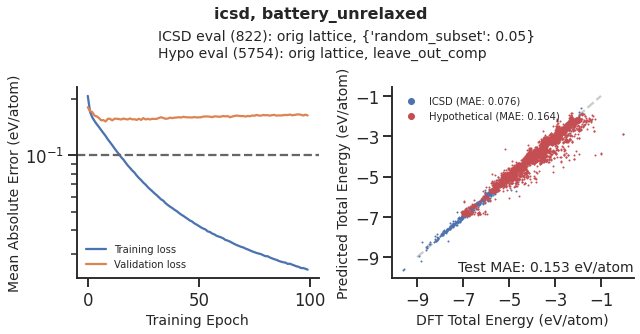

Loading config file 'outputs/icsd_battery_relaxed_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_relaxed_battery_unrelaxed_hypo_loc_icsd_randsub0_05_seed1.svg


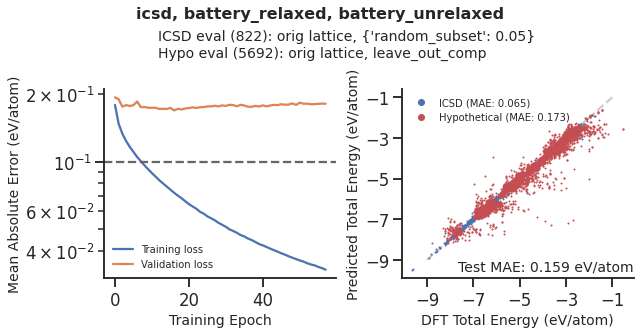

Loading config file 'outputs/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_unrelaxed_hypo_randsub0_05_icsd_randsub0_05_seed1.svg


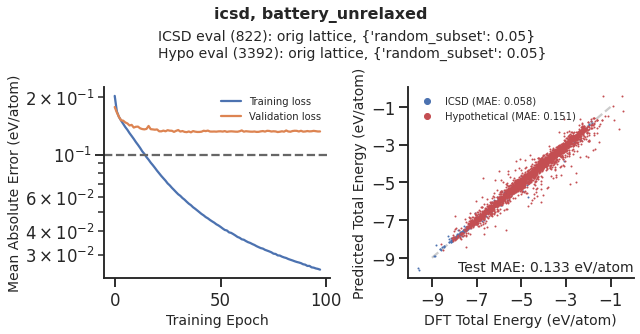

Loading config file 'outputs/icsd_battery_relaxed_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_relaxed_battery_unrelaxed_hypo_randsub0_05_icsd_randsub0_05_seed1.svg


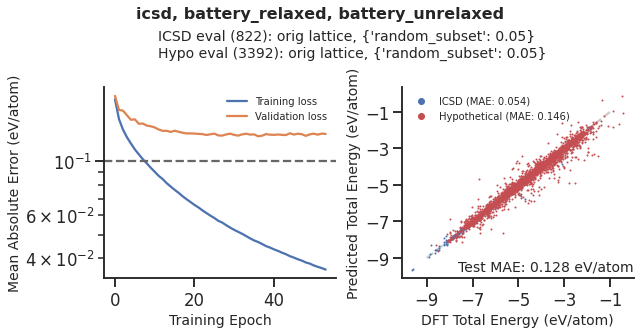

Loading config file 'outputs/icsd_battery_relaxed/hypo_clatt_loc_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_relaxed_hypo_clatt_loc_icsd_randsub0_05_seed1.svg


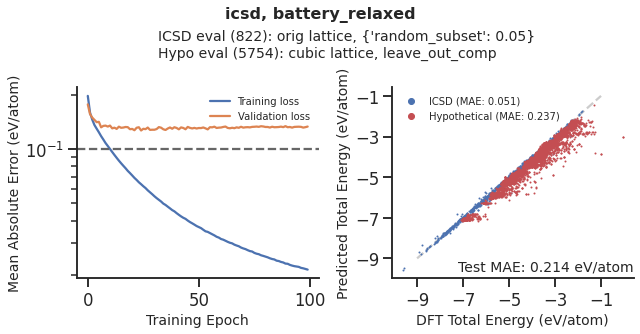

Loading config file 'outputs/icsd_battery_relaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_relaxed_hypo_clatt_randsub0_05_icsd_randsub0_05_seed1.svg


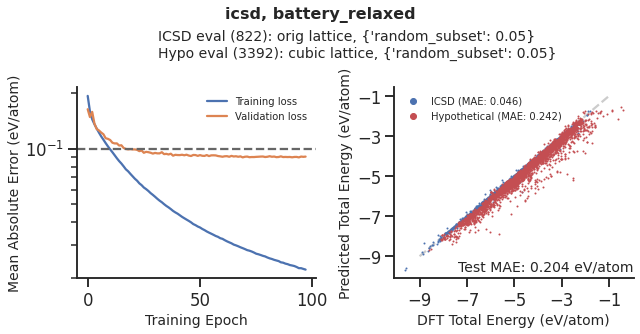

Loading config file 'outputs/icsd_battery_relaxed/hypo_loc_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_relaxed_hypo_loc_icsd_randsub0_05_seed1.svg


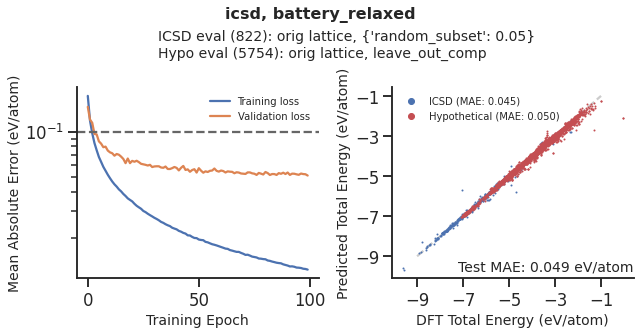

Loading config file 'outputs/icsd_battery_relaxed/hypo_randsub0_05_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_battery_relaxed_hypo_randsub0_05_icsd_randsub0_05_seed1.svg


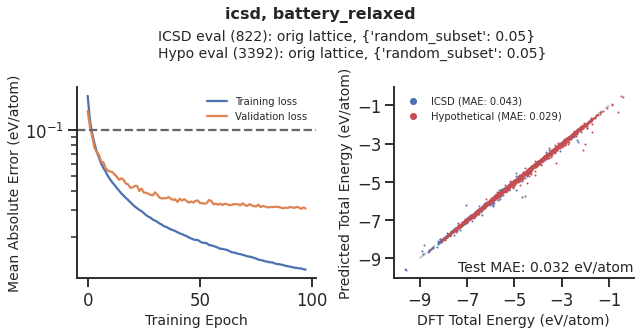

Loading config file 'outputs/icsd_zintl_unrelaxed/hypo_clatt_loc_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_zintl_unrelaxed_hypo_clatt_loc_icsd_randsub0_05_seed1.svg


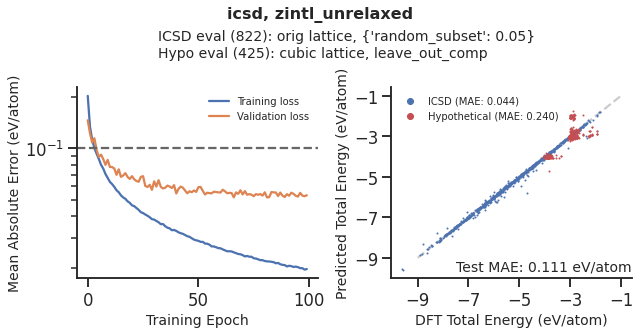

Loading config file 'outputs/icsd_zintl_unrelaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_zintl_unrelaxed_hypo_clatt_randsub0_05_icsd_randsub0_05_seed1.svg


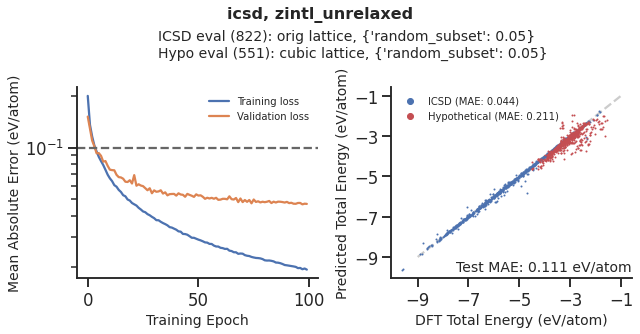

Loading config file 'outputs/icsd_zintl_unrelaxed/hypo_loc_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_zintl_unrelaxed_hypo_loc_icsd_randsub0_05_seed1.svg


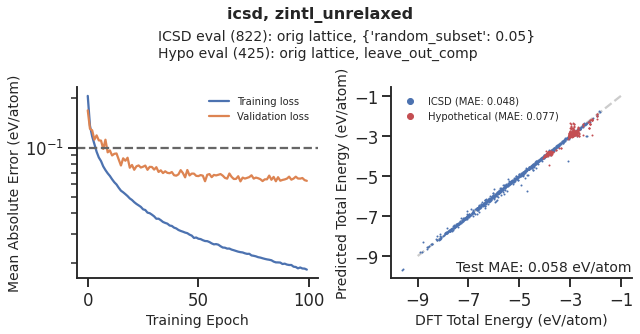

Loading config file 'outputs/icsd_zintl_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1/run.yaml'
writing outputs/viz/train_and_parity/icsd_zintl_unrelaxed_hypo_randsub0_05_icsd_randsub0_05_seed1.svg


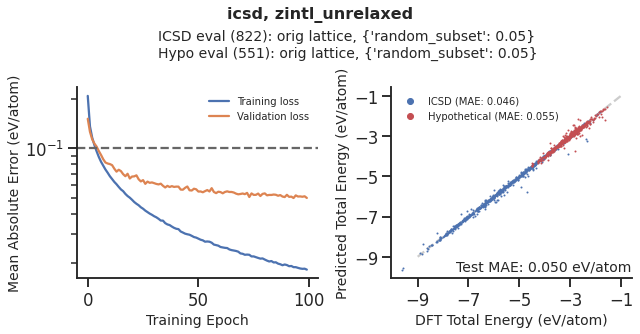

In [18]:
# print("min_val_loss\tepochs\tlog_file")
out_dir = "outputs/viz/train_and_parity"
os.makedirs(out_dir, exist_ok=True)

for exp_dir in exp_dirs:
    log_file = exp_dir + '/log.csv'
    if not os.path.isfile(log_file):
        continue
    df = pd.read_csv(log_file)
    pred_energy_file = exp_dir + '/predicted_test.csv'
    pred_df = pd.read_csv(pred_energy_file)
#     print(f"{df['val_loss'].min():0.2f}\t{df['val_loss'].argmin()}\t{log_file}")
    plot_train_and_parity(exp_dir, df, pred_df, icsd_df, out_dir)

In [12]:
log.val_loss.min()

0.13065117597579956

# 2021-08-27 Backup of old code:

## Load the model and preprocessor

In [42]:
import pickle
import tensorflow as tf
import nfp
from nfp_extensions import RBFExpansion, CifPreprocessor

# Initialize the preprocessor class.
preprocessor = CifPreprocessor(num_neighbors=12)
preprocessor.from_json('tfrecords2/preprocessor.json')
    
model = tf.keras.models.load_model(
    'trained_model2/best_model.hdf5',
    custom_objects={**nfp.custom_objects, **{'RBFExpansion': RBFExpansion}})

## Load the test data and convert to model inputs (using pymatgen)

In [43]:
from pymatgen.core.structure import Structure
from tqdm import tqdm

In [44]:
test = pd.read_csv('tfrecords2/test.csv.gz')

cif_file = lambda x: '/scratch/pstjohn/utf8_cifs/icsd_{:06d}.cif'.format(x)
get_crystal = lambda x: Structure.from_file(cif_file(x), primitive=True)

Example crystal parsing

In [45]:
get_crystal(test.icsdnum.iloc[1])

Structure Summary
Lattice
    abc : 6.1017 6.2504 7.452167877872854
 angles : 114.79468686451068 103.41334283277807 90.0
 volume : 249.4459374521661
      A : 0.0 0.0 -6.1017
      B : -1.005140980953885e-15 -6.2504 -3.827266176695308e-16
      C : -6.540602754873803 3.1252 1.7287124234346232
PeriodicSite: C4+ (-4.5392, 1.4132, -4.2235) [0.8888, 0.1209, 0.6940]
PeriodicSite: C4+ (-2.0014, -1.7120, -3.2004) [0.6112, 0.4269, 0.3060]
PeriodicSite: C4+ (-2.0014, -4.5384, -0.1495) [0.1112, 0.8791, 0.3060]
PeriodicSite: C4+ (-4.5392, -1.4132, -1.1726) [0.3888, 0.5731, 0.6940]
PeriodicSite: La3+ (-5.2231, 1.7849, -1.2102) [0.4246, 0.1137, 0.7986]
PeriodicSite: La3+ (-1.3175, -1.3403, -0.1120) [0.0754, 0.3151, 0.2014]
PeriodicSite: La3+ (-1.3175, -4.9101, -3.1628) [0.5754, 0.8863, 0.2014]
PeriodicSite: La3+ (-5.2231, -1.7849, -4.2610) [0.9246, 0.6849, 0.7986]
PeriodicSite: N3- (-2.7274, 0.9857, -0.8210) [0.2527, 0.0508, 0.4170]
PeriodicSite: N3- (-3.8132, -2.1395, -0.5011) [0.2473, 0.6338, 0.5

Create a tf.data pipeline

In [46]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(get_crystal(icsdnum), train=False)
             for icsdnum in tqdm(test.icsdnum)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

## Predict the test crystals.
The slow step here is definitely loading the CIF files and creating the primitive cell

In [47]:
predictions = model.predict(test_dataset)

  2%|▏         | 10/500 [00:01<02:05,  3.91it/s]/projects/rlmolecule/pstjohn/envs/tf2_pymatgen/lib/python3.7/site-packages/pymatgen/io/cif.py:1122: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))
100%|██████████| 500/500 [01:40<00:00,  4.95it/s]


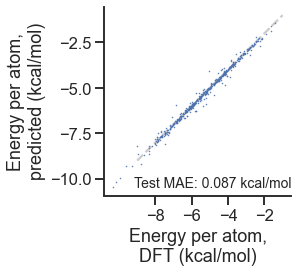

In [48]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(test.energyperatom, predictions, '.', ms=1)
ax.plot([-9, -1], [-9, -1], '--', color='.8', zorder=0)
ax.set_xticks([-2, -4, -6, -8])
plt.ylabel('Energy per atom,\npredicted (eV/atom)')
plt.xlabel('Energy per atom,\nDFT (eV/atom)')
plt.tight_layout()

ax.text(1., 0.025, f'Test MAE: {(test.energyperatom - predictions.squeeze()).abs().mean():.3f} eV/atom',
        ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

sns.despine(trim=False)
plt.savefig('figs/test_parity.svg')

In [51]:
test['predicted_energyperatom'] = predictions

In [54]:
test.to_csv('trained_model2/predicted.csv', index=False)

Looks like we can speed up evaluation at test-time by not creating the primitive crystal. And good to validate that the predictions are (almost) identical between the two methods. Note, this changes the underlying graph structure as well

In [ ]:
get_crystal_no_primitive = lambda x: Structure.from_file(cif_file(x), primitive=False)
test_dataset_no_primitive = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(
        get_crystal_no_primitive(icsdnum), train=False)
             for icsdnum in tqdm(test.icsdnum)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

predictions_no_primitive = model.predict(test_dataset_no_primitive)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax = plt.plot(predictions, predictions_no_primitive, '.', ms=1)

Might be worth looking into why we're not getting perfect predictions for these

In [ ]:
test['prim_err'] = np.abs(predictions_no_primitive - predictions)
test.sort_values('prim_err', ascending=False).head(10)